# Project 1 
#### by Fabio, Ivan and Olivier

## Data Import

In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import *

# Loading the training data
y, tX, ids = load_csv_data('data/train.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preprocessing

### Undefined values visualization

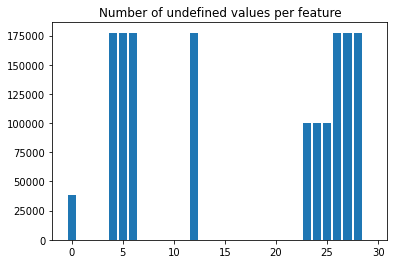

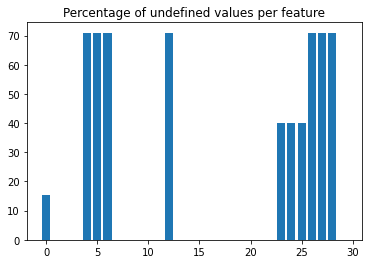

Percentage of inputs with at least one undefined feature:  72.7544


In [4]:
#Counting the number of undefined values and the percentage of undefined values
counter = np.sum((tX == -999), axis = 0)
undef_ind = np.nonzero(counter)[0]
plt.bar(np.arange(len(counter)), counter)
plt.title("Number of undefined values per feature") 
plt.show()

#Percentage of undefined values
N = tX.shape[0]
rel_counter = counter / N * 100
plt.bar(np.arange(len(rel_counter)), rel_counter)
plt.title("Percentage of undefined values per feature") 
plt.show()

#Counting the percentage of inputs with at least one undefined feature 
counter = np.sum((tX == -999), axis = 1)
tot = np.count_nonzero(counter)
print("Percentage of inputs with at least one undefined feature: ", tot / N * 100)

Notes:
* Same number of undefined features for some features. This are structurally missing features.
* Very high percentage for some particular features.

### Dataset splitting

In [5]:
# Splitting dataset into train and validation sets
ratio = 0.8  # Ratio of samples to use in new train set
cut_off_point = int(ratio*len(y))
np.random.seed(0)  # Fixing a seed for reproducibility
rand_ind = np.random.permutation(np.arange(len(y)))
y_train, y_valid = y[cut_off_point:], y[:cut_off_point]
tX_train, tX_valid = tX[cut_off_point:], tX[:cut_off_point]

### Replacing undefined entries

In [6]:
#Replacing undefined entrance:
tX_train_nan = np.where(tX_train != -999, tX_train, np.nan)
tX_valid_nan = np.where(tX_valid != -999, tX_valid, np.nan)

#1. With zero entries
tX_train_zeros = np.where(~np.isnan(tX_train_nan), tX_train_nan, 0)
tX_valid_zeros = np.where(~np.isnan(tX_valid_nan), tX_valid_nan, 0) 
tX_train_zeros = standardize(tX_train_zeros)
tX_valid_zeros = standardize(tX_valid_zeros)


#2. With mean
mu_train = np.nanmean(tX_train_nan, axis = 0)
tX_train_mean = np.where(~np.isnan(tX_train_nan), tX_train_nan, mu_train)
tX_train_mean = standardize(tX_train_mean)
mu_valid = np.nanmean(tX_valid_nan, axis = 0)
tX_valid_mean = np.where(~np.isnan(tX_valid_nan), tX_valid_nan, mu_valid)
tX_valid_mean = standardize(tX_valid_mean)

#3. With median
mu_train = np.nanmedian(tX_train_nan, axis = 0)
tX_train_median = np.where(~np.isnan(tX_train_nan), tX_train_nan, mu_train)
tX_train_median = standardize(tX_train_median)
mu_valid = np.nanmedian(tX_valid_nan, axis = 0)
tX_valid_median = np.where(~np.isnan(tX_valid_nan), tX_valid_nan, mu_valid)
tX_valid_median = standardize(tX_valid_median)

#4. Adding a binary variable
tX_train_binary = np.hstack((tX_train, (2*np.isnan(tX_train_nan[:, undef_ind]) - 1)))
tX_train_binary = standardize(tX_train_binary)
tX_valid_binary = np.hstack((tX_valid, (2*np.isnan(tX_valid_nan[:, undef_ind]) - 1)))
tX_valid_binary = standardize(tX_valid_binary)

#5. Removing features with a percentage of undefined inputs above the threshold
threshold = 0.7
counter = np.sum((tX == -999), axis = 0) / N
keep = np.argwhere(counter < threshold).flatten()
tX_train_del = tX_train[:, keep]
tX_train_del = standardize(tX_train_del)
tX_valid_del = tX_valid[:, keep]
tX_valid_del = standardize(tX_valid_del)

In [7]:
# Standardizing the data
tX_train = standardize(tX_train)
tX_valid = standardize(tX_valid)

# Creating a dictionary of traning and validation sets
train_dict = {'normal': tX_train, 'zeros': tX_train_zeros, 'mean': tX_train_mean, 'median': tX_train_median, 'binary': tX_train_binary, 'deleted': tX_train_del}
valid_dict = {'normal': tX_valid, 'zeros': tX_valid_zeros, 'mean': tX_valid_mean, 'median': tX_valid_median, 'binary': tX_valid_binary, 'deleted': tX_valid_del}

## Scoring functions

In [8]:
def f1_score(y_valid, tX_valid, weights):
    """
    Return the F1-score achieved with the predictions of a validation set

    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    f1 : float
        F1-score for this configuration (the closer to 1 the better)

    References
    ----------
    [1] Wikipedia entry for 'Precision and recall'
        https://en.wikipedia.org/wiki/Precision_and_recall
    [2] Wikipedia entry for 'F-score'
        https://en.wikipedia.org/wiki/F-score

    """

    y_pred = predict_labels(weights, tX_valid) # Obtaining the predictions

    # Calculating number of true positives, false positives, and false negatives
    num_tp = np.sum((y_valid == 1) & (y_pred == 1))
    num_fp = np.sum((y_valid == -1) & (y_pred == 1))
    num_fn = np.sum((y_valid == 1) & (y_pred == -1))
    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)
    f1 = np.round(2 * precision * recall / (precision + recall), 4)
    return f1

In [9]:
def accuracy(y_valid, tX_valid, weights):
    """
    Return the accuracy achieved with the predictions of a validation set

    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    acc : float
        Accuracy for this configuration (the closer to 1 the better)

    References
    ----------
    [3] Wikipedia entry for 'Accuracy and precision'
        https://en.wikipedia.org/wiki/Accuracy_and_precision

    """

    y_pred = predict_labels(weights, tX_valid) # Obtaining the predictions
    num_tp_tn = np.sum(y_valid == y_pred) # Calculating number of true positives and negatives
    acc = np.round(num_tp_tn / len(y_valid), 4)
    return acc

In [10]:
def f1_score_predictions(y_valid, y_pred):
    """
    Return the F1-score achieved with the predictions of a validation set
    
    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    y_pred : np.ndarray
        Vector containing the predictions.

    Returns
    -------
    f1 : float
        F1-score for this configuration (the closer to 1 the better)

    References
    ----------
    [1] Wikipedia entry for the Precision and recall
        https://en.wikipedia.org/wiki/Precision_and_recall
    [2] Wikipedia entry for F-score
        https://en.wikipedia.org/wiki/F-score

    """

    # Calculating number of true positives, false positives, and false negatives
    num_tp = np.sum((y_valid == 1) & (y_pred == 1))
    num_fp = np.sum((y_valid == -1) & (y_pred == 1))
    num_fn = np.sum((y_valid == 1) & (y_pred == -1))

    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)
    f1 = np.round(2 * precision * recall / (precision + recall),4)
    return f1

## Dummy preprocessing testing

In [11]:
lambda_ = 0.001
for key in train_dict:
    weights, loss = ridge_regression(y_train, train_dict[key], lambda_)
    f1 = f1_score(y_valid, valid_dict[key], weights)
    acc = accuracy(y_valid, valid_dict[key], weights)
    print("F1-score achieved with 'ridge_regression', dataset ", key, " : F1 = ", f1)
    print("Accuracy achieved with 'ridge_regression', dataset ", key, " : accuracy = ", acc)

F1-score achieved with 'ridge_regression', dataset  normal  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  normal  : accuracy =  0.718
F1-score achieved with 'ridge_regression', dataset  zeros  : F1 =  0.6658
Accuracy achieved with 'ridge_regression', dataset  zeros  : accuracy =  0.7192
F1-score achieved with 'ridge_regression', dataset  mean  : F1 =  0.6652
Accuracy achieved with 'ridge_regression', dataset  mean  : accuracy =  0.7194
F1-score achieved with 'ridge_regression', dataset  median  : F1 =  0.6652
Accuracy achieved with 'ridge_regression', dataset  median  : accuracy =  0.7197
F1-score achieved with 'ridge_regression', dataset  binary  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  binary  : accuracy =  0.7182
F1-score achieved with 'ridge_regression', dataset  deleted  : F1 =  0.6595
Accuracy achieved with 'ridge_regression', dataset  deleted  : accuracy =  0.7069


## Hyperparameter tuning

In [12]:
def cross_validate_score(regressor, y, tX, param, k_fold, score='f1'):    
    """
    'k_fold' cross validate a regressor with parameters 'param', data '(y, TX)' 
    and score the predictions with 'score'

    Parameters
    ----------
    regressor : String
        String that defines which regressor to use
    y : np.ndarray
        Vector with the labels.
    tX : np.ndarray
        Array with the samples as rows and the features as columns.
    param : np.ndarray
        Parameters on weight, gamma and max_iterations
    k_fold : Integer
        Integer that defines how many folds to make
    score : float
        Float of a given performance score (e.g. f1)

    Returns
    -------
    mean : float
    std : float

    """

    fold_size = int(len(y) / k_fold)
    scores = []
    rand_ind = np.random.permutation(np.arange(len(y)))
    for k in range(k_fold):
        valid_ind = rand_ind[k*fold_size:(k+1)*fold_size] # Splitting data set into validation and training set (for current fold)
        tX_train, y_train = tX[valid_ind], y[valid_ind]
        tX_valid, y_valid = np.delete(tX, valid_ind, axis=0), np.delete(y, valid_ind, axis=0)
        weights, _ = eval(regressor)(y_train, tX_train, **param) # Fitting/scoring regressor with the tarining/validation set
        if score == 'f1': # Scoring according to the scoring criterion
            scores.append(f1_score(y_valid, tX_valid, weights))
        else:
            scores.append(accuracy(y_valid, tX_valid, weights))
    return np.mean(scores), np.std(scores, ddof=1)

In [13]:
def cross_validate_degrees(regressor, compute_loss, y_train, tX_train, y_valid, tX_valid, param, k_fold, degrees):    
    """
    'k_fold' cross validate a regressor with parameters 'param', data '(y, TX)' 

    Parameters
    ----------
    regressor : String
        String that defines which regressor to use
    compute_loss : String
        String that defines which loss to use
    y : np.ndarray
        Vector with the labels.
    tX : np.ndarray
        Array with the samples as rows and the features as columns.
    param : np.ndarray
        Parameters on weight, gamma and max_iterations
    k_fold : Integer
        Integer that defines how many folds to make
    degrees : list or int
        List (or int) with the polynomial degrees (or maximum polynomial degree)
        that should be used as basis elements.

    Returns
    -------
    training_mean : float
    valid_mean : float

    """

    fold_size = int(len(y) / k_fold)
    rand_ind = np.random.permutation(np.arange(len(y)))

    losses_tr = []
    losses_va = []

    for k in range(k_fold):
         # Splitting data set into validation and training set (for current fold)
        valid_ind = rand_ind[k*fold_size:(k+1)*fold_size]
        tX_train, y_train = tX[valid_ind], y[valid_ind]
        tX_valid, y_valid = np.delete(tX, valid_ind, axis=0), np.delete(y, valid_ind, axis=0)

        # Form the data with polynomial degree
        tX_train = polynomial_basis(tX_train, degrees, std=True)
        tX_valid = polynomial_basis(tX_valid, degrees, std=True)

        # Train the model and calculate the loss for train and test data
        if (regressor != 'least_squares' and regressor != 'ridge_regression'):   #for least squares and ridge regression
            param['initial_w'] = np.ones(tX_train.shape[1])
        weights, train_loss = eval(regressor)(y_train, tX_train, **param)
        losses_tr.append(train_loss)
        losses_va.append( eval(compute_loss)(y_valid, tX_valid, weights))
                 
    return np.mean(losses_va), np.std(losses_va), np.mean(losses_tr), np.std(losses_tr) 

In [14]:
def get_best_degree_params(regressor, compute_loss, y_train, tX_train, y_valid, tX_valid, max_iters, degrees, k_fold, params, verbose = True):
    '''
    TODO: Description 
    '''
    # For each degree we compute the best lambda and the associated error
    best_degree = float('inf')
    if (compute_loss == 'accuracy' or compute_loss == 'f1_score'):
        best_loss = float('-inf')
    else:
        best_loss = float('inf')
    best_param = {}
    
    for degree in degrees:
        if verbose:
            print("Degree: ", degree)
        for param in params:
            loss_te, _, _, _ = cross_validate_degrees(regressor, compute_loss, y_train, tX_train, y_valid, tX_valid, param, k_fold, degree)
            if verbose:
                print("loss: ", loss_te)
            if (compute_loss == 'accuracy' or compute_loss == 'f1_score'):
                if loss_te > best_loss:
                    best_loss = loss_te
                    best_degree = degree
                    best_param = param  
            else: 
                if loss_te < best_loss:
                    best_loss = loss_te
                    best_degree = degree
                    best_param = param

        # Least squares has no parameters, we just need to find the optimal degree
        if (params == []):
            loss_te, _, _, _ = cross_validate_degrees(regressor, compute_loss, y_train, tX_train, y_valid, tX_valid, {}, k_fold, degree)
            if verbose:
                print("loss: ", loss_te)
            if (compute_loss == 'accuracy' or compute_loss == 'f1_score'):
                if loss_te > best_loss:
                    best_loss = loss_te
                    best_degree = degree 
            else: 
                if loss_te < best_loss:
                    best_loss = loss_te
                    best_degree = degree

    
    print("Best parameters set for '", regressor, "' using '", compute_loss, "' was:")
    print("degree = ", best_degree)
    print("param = ", best_param)
    print("Mean ", compute_loss, " score: ", best_loss)

    return best_degree, best_param

In [15]:
def best_parameters(regressor, y, tX, params, k_fold, score):
    
    """
    Find best parameters from a list of parameters with k_fold cross validation.

    Parameters
    ----------
    regressor : String
        String that defines which regressor to use
    y : np.ndarray
        Vector with the labels.
    tX : np.ndarray
        Array with the samples as rows and the features as columns.
    param : np.ndarray
        Parameters on weight, gamma and max_iterations
    k_fold : Integer
        Integer that defines how many folds to make
    score : float
        Float of a given performance score (e.g. f1)

    """

    max_std_score = 0.0
    max_mean_score = 0.0
    max_param = {}
    for param in params:
        mean_score, std_score = cross_validate_score(regressor, y, tX, param, k_fold, score)
        if mean_score > max_mean_score: # Checking for the best score
            max_mean_score = mean_score
            max_std_score = std_score
            max_param = param
    print("Best parameter set for '", regressor, "' was:")
    print("param = ", max_param)
    print("Mean ", score, " score: ", max_mean_score, " +/- ", max_std_score)

### Least squares gradient descent

In [61]:
#Setting tuning
regressor = 'least_squares_GD'
compute_loss = 'accuracy'
max_iters = 200
k_fold = 4
params = [{'max_iters': max_iters, 'gamma': gamma} for gamma in np.logspace(-3, 0, 10)]
degrees = range(8)
'''
for key in train_dict:
    tX_tr = train_dict[key]
    tX_va = valid_dict[key] 
    print("Preprocessed data: ", key)
'''
tX_tr = tX_train
tX_va = tX_valid

GD_deg, GD_param = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('least_squares_GD, optimal degree: ', GD_deg)
print('least_squares_GD, optimal gamma: ', GD_param['gamma'])

Degree:  0
loss:  0.5125249999999999
loss:  0.49794999999999995
loss:  0.534225
loss:  0.653775
loss:  0.725175
loss:  0.741025
loss:  0.743575
loss:  0.62855
loss:  0.628525
loss:  0.628525
Degree:  1
loss:  0.5126
loss:  0.497825
loss:  0.5342
loss:  0.6536000000000001
loss:  0.725125
loss:  0.7409
loss:  0.7434
loss:  0.628525
loss:  0.628525
loss:  0.628525
Degree:  2
loss:  0.48260000000000003
loss:  0.4979
loss:  0.54395
loss:  0.647075
loss:  0.721425
loss:  0.7521249999999999
loss:  0.628275
loss:  0.6283
loss:  0.6282749999999999
loss:  0.6282249999999999
Degree:  3
loss:  0.49985
loss:  0.50965
loss:  0.5453
loss:  0.664125
loss:  0.74275
loss:  0.7592
loss:  0.628275


C:\Users\ivanb\anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


loss:  0.6283
loss:  0.628275
loss:  0.6283
Degree:  4
loss:  0.49655000000000005
loss:  0.5129
loss:  0.5612249999999999
loss:  0.6913
loss:  0.75095
loss:  0.76205
loss:  0.628025
loss:  0.6280249999999999
loss:  0.62805
loss:  0.0
Degree:  5
loss:  0.504875
loss:  0.5158750000000001
loss:  0.557275
loss:  0.7013750000000001
loss:  0.7495499999999999
loss:  0.628025
loss:  0.62805
loss:  0.628
loss:  0.628025
loss:  0.0
Degree:  6
loss:  0.5055000000000001
loss:  0.5233749999999999
loss:  0.5748
loss:  0.7057
loss:  0.748275
loss:  0.627775
loss:  0.6278
loss:  0.627775
loss:  0.6277750000000001
loss:  0.0
Degree:  7
loss:  0.510775
loss:  0.524675
loss:  0.5637749999999999
loss:  0.7088249999999999
loss:  0.749325
loss:  0.6276999999999999
loss:  0.62765
loss:  0.6277
loss:  0.627675
loss:  0.0
Best parameters set for ' least_squares_GD ' using ' accuracy ' was:
degree =  4
param =  {'max_iters': 200, 'gamma': 0.046415888336127774, 'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1.,

### Least squares stochastic gradient descent

In [77]:
#Setting tuning
regressor = 'least_squares_SGD'
compute_loss = 'accuracy'
max_iters = 20000
k_fold = 4
params = [{'max_iters': max_iters, 'gamma': gamma} for gamma in np.logspace(-3, 0, 10)]
degrees = range(8)
'''
for key in train_dict:
    tX_tr = train_dict[key]
    tX_va = valid_dict[key] 
    print("Preprocessed data: ", key)
'''
tX_tr = tX_train
tX_va = tX_valid

SGD_deg, SGD_param = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('least_squares_SGD, optimal degree: ', SGD_deg)
print('least_squares_SGD, optimal gamma: ', SGD_param['gamma'])

Degree:  0
loss:  0.59985
loss:  0.5997250000000001
loss:  0.599525
loss:  0.5990000000000001
loss:  0.5977250000000001
loss:  0.5952
loss:  0.58795
loss:  0.5678000000000001
loss:  0.5283249999999999
loss:  0.498575
Degree:  1
loss:  0.599825
loss:  0.5996999999999999
loss:  0.5995250000000001
loss:  0.599
loss:  0.5977250000000001
loss:  0.5952
loss:  0.5879
loss:  0.56795
loss:  0.52825
loss:  0.499225
Degree:  2
loss:  0.561375
loss:  0.560875
loss:  0.560025
loss:  0.5578749999999999
loss:  0.553525
loss:  0.542925
loss:  0.523775
loss:  0.497625
loss:  0.48185
loss:  0.49145
Degree:  3
loss:  0.587075
loss:  0.5866250000000001
loss:  0.58595
loss:  0.5842499999999999
loss:  0.5812499999999999
loss:  0.572725
loss:  0.55035
loss:  0.512525
loss:  0.5013
loss:  0.5138
Degree:  4
loss:  0.558925
loss:  0.5582750000000001
loss:  0.5560499999999999
loss:  0.55245
loss:  0.545375
loss:  0.5309999999999999
loss:  0.508375
loss:  0.48745000000000005
loss:  0.493025
loss:  0.5152749999999

### Least squares

In [73]:
#Setting tuning
regressor = 'least_squares'
compute_loss = 'accuracy'
max_iters = None
k_fold = 4
params = []
degrees = range(8)
'''
for key in train_dict:
    tX_tr = train_dict[key]
    tX_va = valid_dict[key] 
    print("Preprocessed data: ", key)
'''
tX_tr = tX_train
tX_va = tX_valid

ls_deg, ls_param = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('ls_squares_SGD, optimal degree: ', ls_deg)

print('----------------------------------------------------')
print('------------------ NO OFFSET TERM ------------------')
print('----------------------------------------------------')
degrees = []
for deg in range(1,8):
    degrees.append(range(1, deg+1))

ls_deg, ls_param = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('ls_squares_SGD, optimal degree with no offset: ', ls_deg)


range(0, 8)
Degree:  0
loss:  0.627775
Degree:  1
loss:  0.66855
Degree:  2
loss:  0.47709999999999997
Degree:  3
loss:  0.499675
Degree:  4
loss:  0.47364999999999996
Degree:  5
loss:  0.500625
Degree:  6
loss:  0.492625
Degree:  7
loss:  0.47352500000000003
Best parameters set for ' least_squares ' using ' accuracy ' was:
degree =  1
param =  {}
Mean  accuracy  score:  0.66855
ls_squares_SGD, optimal degree:  1
----------------------------------------------------
------------------ NO OFFSET TERM ------------------
----------------------------------------------------
Degree:  range(1, 2)
loss:  0.46735
Degree:  range(1, 3)
loss:  0.5188750000000001
Degree:  range(1, 4)
loss:  0.4998
Degree:  range(1, 5)
loss:  0.482475
Degree:  range(1, 6)
loss:  0.5484
Degree:  range(1, 7)
loss:  0.5500999999999999
Degree:  range(1, 8)
loss:  0.500375
Best parameters set for ' least_squares ' using ' accuracy ' was:
degree =  range(1, 7)
param =  {}
Mean  accuracy  score:  0.5500999999999999
ls_squa

### Ridge regression

In [83]:
#Setting tuning
regressor = 'ridge_regression'
compute_loss = 'accuracy'
max_iters = None
k_fold = 4
params = [{'lambda_': lambda_} for lambda_ in np.logspace(-3, 0, 10)]
degrees = range(8)
'''
for key in train_dict:
    tX_tr = train_dict[key]
    tX_va = valid_dict[key] 
    print("Preprocessed data: ", key)
'''
tX_tr = tX_train
tX_va = tX_valid

ridge_deg, ridge_param = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('least_squares_GD, optimal degree: ', ridge_deg)
print('least_squares_GD, optimal gamma: ', ridge_param['lambda_'])

Degree:  0
loss:  0.743975
loss:  0.7438
loss:  0.743675
loss:  0.743325
loss:  0.742475
loss:  0.7399249999999999
loss:  0.735425
loss:  0.7272
loss:  0.71615
loss:  0.701375
Degree:  1
loss:  0.7441
loss:  0.743975
loss:  0.743625
loss:  0.743375
loss:  0.7425
loss:  0.7401249999999999
loss:  0.735225
loss:  0.7271
loss:  0.7160500000000001
loss:  0.701425
Degree:  2
loss:  0.760825
loss:  0.7611000000000001
loss:  0.7602
loss:  0.7584
loss:  0.7563500000000001
loss:  0.753425
loss:  0.750175
loss:  0.7453249999999999
loss:  0.737425
loss:  0.7214
Degree:  3
loss:  0.768125
loss:  0.76595
loss:  0.765225
loss:  0.763
loss:  0.75945
loss:  0.7552500000000001
loss:  0.7502
loss:  0.74425
loss:  0.73515
loss:  0.7188999999999999
Degree:  4
loss:  0.767325
loss:  0.76665
loss:  0.764975
loss:  0.763025
loss:  0.7602249999999999
loss:  0.756325
loss:  0.75135
loss:  0.7447999999999999
loss:  0.7369
loss:  0.7219749999999999
Degree:  5
loss:  0.7685
loss:  0.76825
loss:  0.76625
loss:  0.7

### Lasso subgradient descent

In [51]:
from itertools import product
#Setting tuning
regressor = 'lasso_SD'
compute_loss = 'accuracy'
max_iters = 200
k_fold = 4
gammas = np.logspace(-3, 0, 4)
lambdas = np.logspace(-2, 1, 4)
params = [{'max_iters': max_iters, 'gamma': gamma, 'lambda_': lambda_} for gamma, lambda_ in product(gammas, lambdas)]
degrees = range(8)
'''
for key in train_dict:
    tX_tr = train_dict[key]
    tX_va = valid_dict[key] 
    print("Preprocessed data: ", key)
'''
tX_tr = tX_train
tX_va = tX_valid

lasso_SD_deg, lasso_SD_param = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('least_squares_SGD, optimal degree: ', lasso_SD_deg)
print('least_squares_SGD, optimal gamma: ', lasso_SD_param['gamma'])
print('least_squares_SGD, optimal lambda_: ', lasso_SD_param['lambda_'])

Degree:  0
loss:  0.512575
loss:  0.5125
loss:  0.511575
loss:  0.499825
loss:  0.6541250000000001
loss:  0.658125
loss:  0.6941
loss:  0.58555
loss:  0.7434250000000001
loss:  0.740175
loss:  0.698875
loss:  0.6314


c:\Users\ivanb\Documents\GitHub\ML_project1\implementations.py:645: RuntimeWarning: overflow encountered in square
  loss = np.mean(e**2) / 2
C:\Users\ivanb\anaconda3\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


loss:  0.628525
loss:  0.6285499999999999
loss:  0.628525
loss:  0.628525
Degree:  1
loss:  0.5125500000000001
loss:  0.5125500000000001
loss:  0.5115
loss:  0.49975
loss:  0.6541250000000001
loss:  0.6581250000000001
loss:  0.6940500000000001
loss:  0.5669500000000001
loss:  0.743425
loss:  0.7402
loss:  0.7005
loss:  0.631175
loss:  0.628525
loss:  0.6285
loss:  0.6285
loss:  0.6285
Degree:  2
loss:  0.482575
loss:  0.4823
loss:  0.482225
loss:  0.479925
loss:  0.647825
loss:  0.6514249999999999
loss:  0.6760999999999999
loss:  0.60785
loss:  0.6283000000000001
loss:  0.6283
loss:  0.62825
loss:  0.628325
loss:  0.628275
loss:  0.628275
loss:  0.62825
loss:  0.6282749999999999
Degree:  3
loss:  0.49997499999999995
loss:  0.49997500000000006
loss:  0.49975
loss:  0.49572499999999997
loss:  0.664875
loss:  0.66995
loss:  0.692875
loss:  0.554325
loss:  0.628275
loss:  0.6282749999999999
loss:  0.6283000000000001
loss:  0.6283
loss:  0.628275
loss:  0.6283
loss:  0.6283000000000001
loss

C:\Users\ivanb\anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


loss:  0.62805
loss:  0.6280749999999999
loss:  0.62805
loss:  0.6280249999999999
loss:  0.0
loss:  0.0
loss:  0.0
loss:  0.0
Degree:  5
loss:  0.50465
loss:  0.504825
loss:  0.5045999999999999
loss:  0.504625
loss:  0.7023250000000001
loss:  0.707275
loss:  0.726375
loss:  0.5299999999999999
loss:  0.62805
loss:  0.62805
loss:  0.6280499999999999
loss:  0.628025
loss:  0.0
loss:  0.0
loss:  0.0
loss:  0.0
Degree:  6
loss:  0.505575
loss:  0.5058750000000001
loss:  0.50615
loss:  0.5101249999999999
loss:  0.708775
loss:  0.7156750000000001
loss:  0.7314
loss:  0.5704
loss:  0.627775
loss:  0.627775
loss:  0.627825
loss:  0.627775
loss:  0.0
loss:  0.0
loss:  0.0
loss:  0.0
Degree:  7
loss:  0.5101249999999999
loss:  0.5105500000000001
loss:  0.509825
loss:  0.511625
loss:  0.709125
loss:  0.7135
loss:  0.734175
loss:  0.469975
loss:  0.627675
loss:  0.627675
loss:  0.627675
loss:  0.6276999999999999
loss:  0.0
loss:  0.0
loss:  0.0
loss:  0.0
Best parameters set for ' lasso_SD ' using 

### Logistic regressor

In [52]:
#Setting tuning
regressor = 'logistic_regression'
compute_loss = 'accuracy'
max_iters = 20
k_fold = 4
params = [{'max_iters': max_iters, 'gamma': gamma} for gamma in np.logspace(-4, 1, 10)]
degrees = range(8)
'''
for key in train_dict:
    tX_tr = train_dict[key]
    tX_va = valid_dict[key] 
    print("Preprocessed data: ", key)
'''
tX_tr = tX_train
tX_va = tX_valid

logistic_regression_deg, logistic_regression_param = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('logistic_regression, optimal degree: ', logistic_regression_deg)
print('logistic_regression, optimal gamma: ', logistic_regression_param['gamma'])

Degree:  0
loss:  0.6438
loss:  0.65635
loss:  0.66035
loss:  0.6613
loss:  0.6613500000000001
loss:  0.661
loss:  0.661225
loss:  0.661225
loss:  0.661275
loss:  0.661025
Degree:  1
loss:  0.62915
loss:  0.656275
loss:  0.6602
loss:  0.6605000000000001
loss:  0.66125
loss:  0.661175
loss:  0.66135
loss:  0.661475
loss:  0.66125
loss:  0.661625
Degree:  2
loss:  0.658375
loss:  0.660525
loss:  0.6617500000000001
loss:  0.6618
loss:  0.66225
loss:  0.66235
loss:  0.6618999999999999
loss:  0.662325
loss:  0.6620250000000001
loss:  0.661675
Degree:  3
loss:  0.6584000000000001
loss:  0.6504
loss:  0.6513249999999999
loss:  0.6515
loss:  0.651475
loss:  0.651325
loss:  0.651325
loss:  0.651
loss:  0.6512249999999999
loss:  0.6516
Degree:  4
loss:  0.612825
loss:  0.648425
loss:  0.648825
loss:  0.6484500000000001
loss:  0.648475
loss:  0.6485000000000001
loss:  0.6487499999999999
loss:  0.64845
loss:  0.6488
loss:  0.648725
Degree:  5
loss:  0.6444749999999999
loss:  0.645675
loss:  0.6471

### Regularized logistic regressor

In [53]:
#Setting tuning
regressor = 'reg_logistic_regression'
compute_loss = 'accuracy'
max_iters = 20
k_fold = 4
gammas = np.logspace(-3, 0, 4)
lambdas = np.logspace(-2, 1, 4)
params = [{'max_iters': max_iters, 'gamma': gamma, 'lambda_': lambda_} for gamma, lambda_ in product(gammas, lambdas)]
degrees = range(8)
'''
for key in train_dict:
    tX_tr = train_dict[key]
    tX_va = valid_dict[key] 
    print("Preprocessed data: ", key)
'''
tX_tr = tX_train
tX_va = tX_valid

reg_logistic_regression_deg, reg_logistic_regression_param = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('reg_logistic_regression, optimal degree: ', reg_logistic_regression_deg)
print('logistic_regression, optimal gamma: ', reg_logistic_regression_param['gamma'])
print('logistic_regression, optimal lambda_: ', reg_logistic_regression_param['lambda_'])

Degree:  0
loss:  0.65985
loss:  0.65985
loss:  0.6591750000000001
loss:  0.652225
loss:  0.661075
loss:  0.6606000000000001
loss:  0.6537250000000001
loss:  0.6393
loss:  0.66055
loss:  0.653575
loss:  0.6393
loss:  0.63035
loss:  0.65355
loss:  0.63925
loss:  0.63035
loss:  0.621325
Degree:  1
loss:  0.659875
loss:  0.6599999999999999
loss:  0.6590499999999999
loss:  0.6522249999999999
loss:  0.661175
loss:  0.660175
loss:  0.653575
loss:  0.639275
loss:  0.6603000000000001
loss:  0.65335
loss:  0.6392500000000001
loss:  0.630325
loss:  0.6535
loss:  0.63925
loss:  0.63035
loss:  0.6213249999999999
Degree:  2
loss:  0.661475
loss:  0.66125
loss:  0.661125
loss:  0.656075
loss:  0.659725
loss:  0.6611750000000001
loss:  0.6567000000000001
loss:  0.6365500000000001
loss:  0.6613
loss:  0.657175
loss:  0.6363750000000001
loss:  0.6292
loss:  0.6562
loss:  0.636475
loss:  0.6292
loss:  0.61405
Degree:  3
loss:  0.65125
loss:  0.6510750000000001
loss:  0.65035
loss:  0.6470750000000001
lo

In [54]:
def sigmoid(t):
    """
    apply the sigmoid function on t.
    TODO: Description
    """
    return 1 / (1 + np.exp(-t))

def calculate_loss_logistic(y, tx, w):
    """
    compute the loss: negative log likelihood.
    """
    sigma = sigmoid(tx @ w)
    loss = - np.sum(y * np.log( sigma ) + (1 - y) * np.log( 1 - sigma ) )
    return loss

def calculate_gradient_logistic(y, tx, w):
    """
    compute the gradient of loss.
    TODO: Description
    """
    grad = np.dot(tx.T, (sigmoid(np.dot(tx, w)) - y))
    return grad

def m_logistic_regression(y, tX, initial_w=None, max_iters=100, gamma=0.1):
    """
    TODO: Description
    """
    if len(tX.shape) == 1: # Checking if 'tX' is a 1D array
        tX = tX.reshape((-1, 1)) # consequently converting to a 2D array

    # Zero vector for 'initial_w' if no initial value was specified
    if initial_w is None:
        initial_w = np.zeros(tX.shape[1])
    
    # Converting 1D arrays to 2D arrays
    w = initial_w.reshape((-1, 1))
    y = y.reshape((-1, 1))
 
    for _ in range(max_iters):
        grad = calculate_gradient_logistic(y, tX, w)
        w = w - gamma * grad # Updating weights with scaled negative gradient
    
    # Computing loss for the weights of the final iteration
    loss = calculate_loss_logistic(y, tX, w)
    w = w.reshape(-1) # Converting weights back to 1D arrays
    return w, loss

def m_reg_logistic_regression(y, tX, initial_w=None, max_iters=100, gamma=0.1, lambda_ = 1):
    """
    TODO: Description
    """
    if len(tX.shape) == 1: # Checking if 'tX' is a 1D array
        tX = tX.reshape((-1, 1)) # consequently converting to a 2D array

    # Zero vector for 'initial_w' if no initial value was specified
    if initial_w is None:
        initial_w = np.zeros(tX.shape[1])
    
    # Converting 1D arrays to 2D arrays
    w = initial_w.reshape((-1, 1))
    y = y.reshape((-1, 1))
 
    for _ in range(max_iters):
        grad = calculate_gradient_logistic(y, tX, w) + lambda_ * w
        w = w - gamma * grad # Updating weights with scaled negative gradient
    
    # Computing loss for the weights of the final iteration
    loss = calculate_loss_logistic(y, tX, w) + lambda_ / 2 * np.linalg.norm(w)
    w = w.reshape(-1) # Converting weights back to 1D arrays
    return w, loss



In [55]:
#Setting tuning
regressor = 'm_logistic_regression'
compute_loss = 'accuracy'
max_iters = 25
k_fold = 4
params = [{'max_iters': max_iters, 'gamma': gamma} for gamma in np.logspace(-4, 1, 10)]
degrees = range(8)
'''
for key in train_dict:
    tX_tr = train_dict[key]
    tX_va = valid_dict[key] 
    print("Preprocessed data: ", key)
'''
tX_tr = tX_train
tX_va = tX_valid

m_logistic_regression_deg, m_logistic_regression_param = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('m_logistic_regression, optimal degree: ', m_logistic_regression_deg)
print('m_logistic_regression, optimal gamma: ', m_logistic_regression_param['gamma'])

Degree:  0


<ipython-input-54-a0efaedea64c>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
<ipython-input-54-a0efaedea64c>:13: RuntimeWarning: divide by zero encountered in log
  loss = - np.sum(y * np.log( sigma ) + (1 - y) * np.log( 1 - sigma ) )
<ipython-input-54-a0efaedea64c>:13: RuntimeWarning: invalid value encountered in multiply
  loss = - np.sum(y * np.log( sigma ) + (1 - y) * np.log( 1 - sigma ) )


loss:  0.703025
loss:  0.702425
loss:  0.702425
loss:  0.7022999999999999
loss:  0.702075
loss:  0.702275
loss:  0.702125
loss:  0.7022499999999999
loss:  0.7021750000000001
loss:  0.7022999999999999
Degree:  1
loss:  0.70305
loss:  0.7023999999999999
loss:  0.702375
loss:  0.702175
loss:  0.70225
loss:  0.7023
loss:  0.70225
loss:  0.702175
loss:  0.7022
loss:  0.7021999999999999
Degree:  2
loss:  0.7219500000000001
loss:  0.7218
loss:  0.721925
loss:  0.7219249999999999
loss:  0.7219
loss:  0.721975
loss:  0.7221
loss:  0.72175
loss:  0.7218
loss:  0.72185
Degree:  3
loss:  0.726475
loss:  0.7261500000000001
loss:  0.7262500000000001
loss:  0.7261
loss:  0.726275
loss:  0.7263000000000001
loss:  0.726075
loss:  0.7262500000000001
loss:  0.72615
loss:  0.72605
Degree:  4
loss:  0.730075
loss:  0.730025
loss:  0.730225
loss:  0.730075
loss:  0.730225
loss:  0.730175
loss:  0.7301
loss:  0.730175
loss:  0.73
loss:  0.7300249999999999
Degree:  5
loss:  0.7328749999999999
loss:  0.73285
l

In [56]:
#Setting tuning
regressor = 'm_logistic_regression'
compute_loss = 'accuracy'
max_iters = 25
k_fold = 4
params = [{'max_iters': max_iters, 'gamma': gamma} for gamma in np.logspace(-4, 1, 10)]
degrees = range(8)
'''
for key in train_dict:
    tX_tr = train_dict[key]
    tX_va = valid_dict[key] 
    print("Preprocessed data: ", key)
'''
tX_tr = tX_train_median
tX_va = tX_valid_median

m_logistic_regression_deg_median, m_logistic_regression_param_median = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('m_logistic_regression (median dataset), optimal degree: ', m_logistic_regression_deg_median)
print('m_logistic_regression (median dataset), optimal gamma: ', m_logistic_regression_param_median['gamma'])

Degree:  0


<ipython-input-54-a0efaedea64c>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
<ipython-input-54-a0efaedea64c>:13: RuntimeWarning: divide by zero encountered in log
  loss = - np.sum(y * np.log( sigma ) + (1 - y) * np.log( 1 - sigma ) )
<ipython-input-54-a0efaedea64c>:13: RuntimeWarning: invalid value encountered in multiply
  loss = - np.sum(y * np.log( sigma ) + (1 - y) * np.log( 1 - sigma ) )


loss:  0.7030000000000001
loss:  0.7023999999999999
loss:  0.702375
loss:  0.70225
loss:  0.702225
loss:  0.702375
loss:  0.7022250000000001
loss:  0.7021499999999999
loss:  0.702325
loss:  0.7022250000000001
Degree:  1
loss:  0.703075
loss:  0.7024499999999999
loss:  0.702275
loss:  0.702325
loss:  0.7021999999999999
loss:  0.7022250000000001
loss:  0.7021999999999999
loss:  0.7022499999999999
loss:  0.702325
loss:  0.7022999999999999
Degree:  2
loss:  0.7221500000000001
loss:  0.7219
loss:  0.721925
loss:  0.7219
loss:  0.721775
loss:  0.722
loss:  0.721975
loss:  0.721775
loss:  0.7219500000000001
loss:  0.72195
Degree:  3
loss:  0.726325
loss:  0.72625
loss:  0.726425
loss:  0.7262000000000001
loss:  0.726
loss:  0.726175
loss:  0.726375
loss:  0.7261500000000001
loss:  0.72625
loss:  0.7263000000000001
Degree:  4
loss:  0.7299
loss:  0.7299500000000001
loss:  0.7303
loss:  0.7302
loss:  0.7303000000000001
loss:  0.73035
loss:  0.7302
loss:  0.7302250000000001
loss:  0.730050000000

In [57]:
#Setting tuning
regressor = 'm_reg_logistic_regression'
compute_loss = 'accuracy'
max_iters = 20
k_fold = 4
gammas = np.logspace(-3, 0, 4)
lambdas = np.logspace(-2, 1, 4)
params = [{'max_iters': max_iters, 'gamma': gamma, 'lambda_': lambda_} for gamma, lambda_ in product(gammas, lambdas)]
degrees = range(8)
'''
for key in train_dict:
    tX_tr = train_dict[key]
    tX_va = valid_dict[key] 
    print("Preprocessed data: ", key)
'''
tX_tr = tX_train
tX_va = tX_valid

reg_logistic_regression_deg, reg_logistic_regression_param = get_best_degree_params(regressor, compute_loss, y_train, tX_tr, y_valid, tX_va, max_iters, degrees, k_fold, params)
print('m_reg_logistic_regression, optimal degree: ', reg_logistic_regression_deg)
print('m_logistic_regression, optimal gamma: ', reg_logistic_regression_param['gamma'])
print('m_logistic_regression, optimal lambda_: ', reg_logistic_regression_param['lambda_'])

Degree:  0


<ipython-input-54-a0efaedea64c>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
<ipython-input-54-a0efaedea64c>:13: RuntimeWarning: divide by zero encountered in log
  loss = - np.sum(y * np.log( sigma ) + (1 - y) * np.log( 1 - sigma ) )
<ipython-input-54-a0efaedea64c>:13: RuntimeWarning: invalid value encountered in multiply
  loss = - np.sum(y * np.log( sigma ) + (1 - y) * np.log( 1 - sigma ) )


loss:  0.70215
loss:  0.7023
loss:  0.702275
loss:  0.7023250000000001
loss:  0.702125
loss:  0.702225
loss:  0.7022250000000001
loss:  0.70245
loss:  0.7020249999999999
loss:  0.70215
loss:  0.7026249999999999
loss:  0.630775
loss:  0.7021499999999999
loss:  0.7024
loss:  0.6307499999999999
loss:  0.5838000000000001
Degree:  1
loss:  0.7023
loss:  0.702225
loss:  0.70215
loss:  0.7024250000000001
loss:  0.702025
loss:  0.7021999999999999
loss:  0.702275
loss:  0.70245
loss:  0.7021999999999999
loss:  0.7021999999999999
loss:  0.7023999999999999
loss:  0.6307750000000001
loss:  0.702175
loss:  0.7024999999999999
loss:  0.63075
loss:  0.58385
Degree:  2
loss:  0.721725
loss:  0.721925
loss:  0.72175
loss:  0.7220249999999999
loss:  0.7219
loss:  0.72195
loss:  0.721875
loss:  0.721425
loss:  0.7219
loss:  0.72205
loss:  0.7213499999999999
loss:  0.629625
loss:  0.721975
loss:  0.721475
loss:  0.629625
loss:  0.575775
Degree:  3
loss:  0.726175
loss:  0.72615
loss:  0.7262000000000001
lo

## Regressors

### 1. Least squares gradient descent

In [58]:
# Hyperparameters
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 1300
gamma = 0.013

# Fitting
start = time.time()
weights, loss = least_squares_GD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares_GD': F1 = ", f1)
print("Accuracy achieved with 'least_squares_GD': accuracy = ", acc)

Execution time: 0.7752 sec
F1-score achieved with 'least_squares_GD': F1 =  0.6657
Accuracy achieved with 'least_squares_GD': accuracy =  0.7182


### 2. Least squares stochastic gradient descent

In [59]:
# Hyperparameters
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 9800
gamma = 0.098

# Fitting
start = time.time()
weights, loss = least_squares_SGD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares_SGD': F1 = ", f1)
print("Accuracy achieved with 'least_squares_SGD': accuracy = ", acc)

Execution time: 0.069 sec
F1-score achieved with 'least_squares_SGD': F1 =  0.4584
Accuracy achieved with 'least_squares_SGD': accuracy =  0.5984


### 3. Least squares (normal equation)

In [60]:
# Fitting
start = time.time()
weights, loss = least_squares(y_train, tX_train)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares': F1 = ", f1)
print("Accuracy achieved with 'least_squares': accuracy = ", acc)

Execution time: 0.005 sec
F1-score achieved with 'least_squares': F1 =  0.5537
Accuracy achieved with 'least_squares': accuracy =  0.6826


### 4. Ridge regression (for least square normal equation)

In [61]:
# Hyperparameters
lambda_ = 0.0051

# Fitting
start = time.time()
weights, loss = ridge_regression(y_train, tX_train_binary, lambda_)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid_binary, weights)
acc = accuracy(y_valid, tX_valid_binary, weights)
print("F1-score achieved with 'ridge_regression': F1 = ", f1)
print("Accuracy achieved with 'ridge_regression': accuracy = ", acc)

Execution time: 0.012 sec
F1-score achieved with 'ridge_regression': F1 =  0.6654
Accuracy achieved with 'ridge_regression': accuracy =  0.7174


### 5. Logistic regression

In [62]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = logistic_regression(y, tX, initial_w, max_iters, gamma)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)
print("Accuracy achieved with 'logistic_regression': accuracy = ", acc)

Execution time: 14.1794 sec
F1-score achieved with 'logistic_regression': F1 =  0.5422
Accuracy achieved with 'logistic_regression': accuracy =  0.6055


### 6. Regularized logistic regression

In [63]:
# Hyperparameters
# TODO: test different values of gamma and lambda
lambda_ = 1
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'reg_logistic_regression': F1 = ", f1)
print("Accuracy achieved with 'reg_logistic_regression': accuracy = ", acc)

Execution time: 14.011 sec
F1-score achieved with 'reg_logistic_regression': F1 =  0.5288
Accuracy achieved with 'reg_logistic_regression': accuracy =  0.5831


## Optimized Regressors

In [64]:
#TODO: ADD OPTIMIZED REGRESSORS TESTING

## Generate predictions and save ouput in csv format for submission

In [65]:
#DATA_TEST_PATH = '' # TODO: download train data and supply path here 
#_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [66]:
#OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
#y_pred = predict_labels(weights, tX_test)
#create_csv_submission(ids_test, y_pred, OUTPUT_PATH)